In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import glob
import math
import random
from PIL import Image
import time
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def getTrainImages():

    #Image from only the first 12 drawers is taken during train time
    image_path = "drive/My Drive/Colab Notebooks/siamese_data/omniglot-py/images_background/*/character*/*"
    images = []
    for x in range(1,13):
        image_path1=image_path
        if x<10:
            image_path1+="0"
        image_path1+=str(x)
        image_path1+=".png"
        images += glob.glob(image_path1) 
    print(len(images)) # = 11568
    # print(images[0]) # prints the image name
    return images
  
def getValImages():

    #Image from only the first 12 drawers is taken during train time
    image_path = "drive/My Drive/Colab Notebooks/siamese_data/omniglot-py/images_background/*/character*/*"
    images = []
    for x in range(13,17):
        image_path1=image_path
        if x<10:
            image_path1+="0"
        image_path1+=str(x)
        image_path1+=".png"
        images += glob.glob(image_path1) 
    print(len(images)) # = 11568
    # print(images[0]) # prints the image name
    return images

def getRandomPairedIndices(no, start, end):
    count = 0
    pairs = []
    pair = []
    while (count < no):
        pair = []
        x, y = random.randint(start, end), random.randint(start, end)
        pair.append(x)
        pair.append(y)
        if x==y:
            continue
        if x>y:
            x, y = y, x
        if pair in pairs:
            continue
        pairs.append(pair)
        count+=1;
    return pairs

def getTrainExamples(n = 30000):

    all_images = getTrainImages()
    number_of_char = 964

    # For same characters
    n_same = n / 2
    same_images_per_char = math.ceil(n_same / number_of_char)
    n_same = same_images_per_char * number_of_char
    same_character_examples = []
    char_index = 0
    pair = []
    print_every = 1000
    trans = transforms.ToTensor()
#     We need to get n / number_of_char pairs from a single character (12 drawers)
#     So we will get n / number_of_char random pairs of indexes from 0-11
    for i in range(0, number_of_char):
        indices = getRandomPairedIndices(same_images_per_char, 0, 11)
        for index in indices:
            pair = []
            print(i)
            img1 = Image.open(all_images[index[0]*number_of_char + i])
            img1 = trans(img1).numpy()
            img2 = Image.open(all_images[index[1]*number_of_char + i])
            img2 = trans(img2).numpy()
            pair.append(img1)
            pair.append(img2)
            same_character_examples.append(pair)

#    For different characters
    n_diff = n_same
    count = 0
    i1,i2 = 0,0
    diff_character_examples = []
    while(count<n_diff):
        pair = []
        print("count %d"%(count))
        i1 = random.randint(0,len(all_images)-1)
        i2 = random.randint(0,len(all_images)-1)
        img1 = Image.open(all_images[i1])
        img1 = trans(img1).numpy()
        img2 = Image.open(all_images[i2])
        img2 = trans(img2).numpy()
        pair.append(img1)
        pair.append(img2)
        diff_character_examples.append(pair)
        count+=1

    random.shuffle(same_character_examples)
    random.shuffle(diff_character_examples)
    
    return same_character_examples,diff_character_examples

def getValExamples(n = 1000):

    all_images = getValImages()
    number_of_char = 964

    # For same characters
    n_same = n / 2
    same_images_per_char = math.ceil(n_same / number_of_char)
    n_same = same_images_per_char * number_of_char
    same_character_examples = []
    char_index = 0
    pair = []
    trans = transforms.ToTensor()
#     We need to get n / number_of_char pairs from a single character (4 drawers)
#     So we will get n / number_of_char random pairs of indexes from 0-11
    for i in range(0, number_of_char):
        indices = getRandomPairedIndices(same_images_per_char, 0, 3)
        for index in indices:
            pair = []
            print(i)
            img1 = Image.open(all_images[index[0]*number_of_char + i])
            img1 = trans(img1).numpy()
            img2 = Image.open(all_images[index[1]*number_of_char + i])
            img2 = trans(img2).numpy()
            pair.append(img1)
            pair.append(img2)
            same_character_examples.append(pair)

#    For different characters
    n_diff = n_same
    count = 0
    i1,i2 = 0,0
    diff_character_examples = []
    while(count<n_diff):
        pair = []
        print("count %d"%(count))
        i1 = random.randint(0,len(all_images)-1)
        i2 = random.randint(0,len(all_images)-1)
        img1 = Image.open(all_images[i1])
        img1 = trans(img1).numpy()
        img2 = Image.open(all_images[i2])
        img2 = trans(img2).numpy()
        pair.append(img1)
        pair.append(img2)
        diff_character_examples.append(pair)
        count+=1

    random.shuffle(same_character_examples)
    random.shuffle(diff_character_examples)
    
    return same_character_examples,diff_character_examples

def getTrainBatches(n = 30000, batch_size = 128):
    same_character_examples, diff_character_examples = getTrainExamples(n)
    train_batches = []
    current_batch = []
    current_batch_size = 0
    examples_covered = 0
    print_every = 1000
    while examples_covered < n:
        if examples_covered % 2 == 0:
            current_batch.append(same_character_examples.pop())
        else:
            current_batch.append(diff_character_examples.pop())
        current_batch_size+=1
        if current_batch_size == batch_size:
            train_batches.append(torch.tensor(current_batch))
            current_batch = []
            current_batch_size = 0
        if(examples_covered % print_every == 0):
          print("Loading data.... Complete: %d examples"%(examples_covered))
        examples_covered+=1
    if current_batch_size!=0:
        train_batches.append(torch.tensor(current_batch))

    return train_batches

def getValBatch(n = 1000):
    same_character_examples, diff_character_examples = getValExamples(n)
    val_batch = []
    examples_covered = 0
    while examples_covered < n:
        if examples_covered % 2 == 0:
            val_batch.append(same_character_examples.pop())
        else:
            val_batch.append(diff_character_examples.pop())
        examples_covered+=1
          
    return torch.tensor(val_batch)


In [0]:
class Flatten(nn.Module):
	def forward(self, x):
		N, C, H, W = x.size()
		return x.view(N, -1)

class SiameseNet(nn.Module):
	"""docstring for SiameseNet"""
	def __init__(self):
		super(SiameseNet, self).__init__()
		self.siamese_twin = nn.Sequential(
			nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 10),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size = 2, stride = 2),
			nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 7),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size = 2, stride = 2),
			nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 4),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size = 2, stride = 2),
			nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4),
			nn.ReLU(),
			Flatten(),
			nn.Linear(in_features = 256 * 6 * 6 , out_features = 4096),
			nn.Sigmoid()
			)
		self.final_fc = nn.Linear(in_features = 4096 , out_features = 1)

	def forward(self, x, y):
		x1 = self.siamese_twin(x)
		y1 = self.siamese_twin(y)
		L1 = torch.abs(x1 - y1)
		output = F.sigmoid(self.final_fc(L1))

		return output


In [0]:
start_time = time.time()

def initWeights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.2)
        m.bias.data.normal_(mean = 0.5, std = 0.01)
    elif type(m) == nn.Conv2d:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        m.bias.data.normal_(mean = 0.5, std = 0.01)

def generateLabels(batch_size):
    labels = torch.zeros(batch_size)
    for i in range(batch_size):
        if i%2==0:
            labels[i]=1
    return labels

print("----Loading Data-----")

train_batches = getTrainBatches(n = 30000, batch_size = 128)

print("Data loaded in %s seconds"%(time.time()-start_time))


----Loading Data-----
11568
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
23
23
23
2

In [0]:
start_time = time.time()
print("----Training-----")

loss_record = []

net = SiameseNet()
if torch.cuda.is_available():
  net.cuda()
net.apply(initWeights)

optimizer = optim.Adam(net.parameters(), lr = 0.0005, weight_decay = 0.01)

criterion = nn.BCELoss()

for epoch in range(1,11):
     
    for batch_idx,mini_batch in enumerate(train_batches):

        optimizer.zero_grad()

        batch_size = mini_batch.size()[0]
        img1 = mini_batch[:,0,:,:,:].view(-1,1,105,105)
        img2 = mini_batch[:,1,:,:,:].view(-1,1,105,105)
        labels = generateLabels(batch_size)
        if torch.cuda.is_available():
          img1 = img1.cuda()
          img2 = img2.cuda()
          labels = labels.cuda()
        output = net.forward(img1,img2)
        
        loss = criterion(output, labels)
        current_loss = loss.item()
        loss_record.append(current_loss)
        loss.backward()
        optimizer.step()
        print("Epoch:%d Batch:%d Loss:%.5f Time Lapsed:%s"%(epoch,batch_idx+1,current_loss,time.time() - start_time))


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch:1 Batch:1 Loss:0.72698 Time Lapsed:1313.8271749019623
Epoch:1 Batch:2 Loss:0.71117 Time Lapsed:1314.3754396438599
Epoch:1 Batch:3 Loss:0.70447 Time Lapsed:1314.8875346183777
Epoch:1 Batch:4 Loss:0.67913 Time Lapsed:1315.3959345817566
Epoch:1 Batch:5 Loss:0.68245 Time Lapsed:1315.8970947265625
Epoch:1 Batch:6 Loss:0.70949 Time Lapsed:1316.3952116966248
Epoch:1 Batch:7 Loss:0.66982 Time Lapsed:1316.8918225765228
Epoch:1 Batch:8 Loss:0.67319 Time Lapsed:1317.3857152462006
Epoch:1 Batch:9 Loss:0.67091 Time Lapsed:1317.880896806717
Epoch:1 Batch:10 Loss:0.79053 Time Lapsed:1318.3748378753662
Epoch:1 Batch:11 Loss:0.68876 Time Lapsed:1318.870228767395
Epoch:1 Batch:12 Loss:0.72218 Time Lapsed:1319.366280078888
Epoch:1 Batch:13 Loss:0.67803 Time Lapsed:1319.8620867729187
Epoch:1 Batch:14 Loss:0.68867 Time Lapsed:1320.3553671836853
Epoch:1 Batch:15 Loss:0.66143 Time Lapsed:1320.8471162319183
Epoch:1 Batch:16 Loss:0.64995 Time Lapsed:1321.341605424881
Epoch:1 Batch:17 Loss:0.65677 Time La

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch:1 Batch:235 Loss:0.63702 Time Lapsed:1429.8933022022247
Epoch:2 Batch:1 Loss:0.67442 Time Lapsed:1430.2692713737488
Epoch:2 Batch:2 Loss:0.67818 Time Lapsed:1430.765016078949
Epoch:2 Batch:3 Loss:0.66245 Time Lapsed:1431.2585587501526
Epoch:2 Batch:4 Loss:0.67454 Time Lapsed:1431.755574464798
Epoch:2 Batch:5 Loss:0.67453 Time Lapsed:1432.2459952831268
Epoch:2 Batch:6 Loss:0.65698 Time Lapsed:1432.7389357089996
Epoch:2 Batch:7 Loss:0.64582 Time Lapsed:1433.230196237564
Epoch:2 Batch:8 Loss:0.65415 Time Lapsed:1433.7211742401123
Epoch:2 Batch:9 Loss:0.64959 Time Lapsed:1434.212962627411
Epoch:2 Batch:10 Loss:0.62009 Time Lapsed:1434.7052590847015
Epoch:2 Batch:11 Loss:0.64714 Time Lapsed:1435.1967554092407
Epoch:2 Batch:12 Loss:0.63681 Time Lapsed:1435.6895546913147
Epoch:2 Batch:13 Loss:0.63918 Time Lapsed:1436.1834745407104
Epoch:2 Batch:14 Loss:0.65291 Time Lapsed:1436.6794066429138
Epoch:2 Batch:15 Loss:0.66238 Time Lapsed:1437.1763083934784
Epoch:2 Batch:16 Loss:0.66740 Time L

In [0]:
print(len(loss_record))

[0.7076987624168396, 0.7225147485733032, 0.7165759801864624, 0.7298787832260132, 0.7030159831047058, 0.743156373500824, 0.7402607798576355, 0.7039266228675842, 0.7098508477210999, 0.7046946287155151, 0.7245258092880249, 0.6978224515914917, 0.6967889070510864, 0.6774802803993225, 0.7045502662658691, 0.6795226335525513, 0.6851814985275269, 0.8561598062515259, 0.6737961173057556, 0.6774557828903198, 0.8075658082962036, 0.721304178237915, 0.7367104887962341, 0.725483775138855, 0.6992942690849304, 0.7190018892288208, 0.747026264667511, 0.6916962265968323, 0.7013922929763794, 0.6973991394042969, 0.7323011159896851, 0.7425796985626221, 0.7229002714157104, 0.7096139192581177, 0.6965094208717346, 0.7158742547035217, 0.6942756175994873, 0.6926731467247009, 0.6771824359893799, 0.6821495294570923, 0.7084599137306213, 0.8427456617355347, 0.6949342489242554, 0.7188019752502441, 0.6963271498680115, 0.7451068162918091, 0.7792149782180786, 0.7377502918243408, 0.7136754989624023, 0.7948932647705078, 0.6

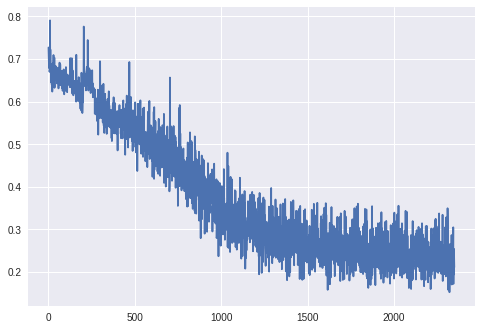

In [0]:
import matplotlib.pyplot as plt
plt.plot(loss_record)
plt.show()

In [7]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 21.8MB/s 


In [0]:
torch.save(net.state_dict(), 'siamese.pth')   
model_file = drive.CreateFile({'title' : 'siamese.pth'})
model_file.SetContentFile('siamese.pth')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})



GoogleDriveFile({'id': '1FJJebkN8ZAdAgkfz0KlinPfdr3ssGOOi'})

In [14]:
with torch.no_grad() :
  
  last_weight_file = drive.CreateFile({'id': '1FJJebkN8ZAdAgkfz0KlinPfdr3ssGOOi'}) 
  last_weight_file.GetContentFile('siamese.pth')
  net = SiameseNet()
  net.load_state_dict(torch.load('siamese.pth'))
  net.eval()
  val_batch = getValBatch()
  
  
  

3856
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

In [18]:
with torch.no_grad():
  img1 = val_batch[:,0,:,:,:].view(-1,1,105,105)
  img2 = val_batch[:,1,:,:,:].view(-1,1,105,105)
  if torch.cuda.is_available():
    net.cuda()
    img1 = img1.cuda()
    img2 = img2.cuda()
  output = net.forward(img1,img2)
  output = output >= 0.5
  correct = 0
  for i in range(len(val_batch)):
    if(i%2 == 0):
      if(output[i] == 1):
        correct += 1
    else:
      if(output[i] == 0):
        correct += 1
  print(correct/float(len(val_batch)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.912
